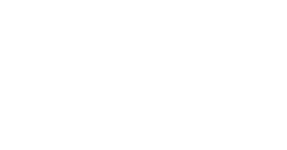

In [62]:
# Mount google drive to access images and labels
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pandas numpy matplotlib

In [ ]:
pip install scikit-learn tensorflow simpleaudio

In [63]:
# Import required packages
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Load MRI images in .npy format and corresponding labels from a .csv file

# Load MRI images and separate each slice, skip images without labels
def load_mri_images(directory, labels):

    slices = []
    acl_tear_labels = []

    # Convert the filename column to string for comparison
    labels['0000'] = labels['0000'].astype(str)

    for filename in os.listdir(directory):
        if filename.endswith(".npy"):
            # Remove the .npy extension and check as string
            stripped_filename = filename[:-4]
            if stripped_filename in labels['0000'].values:
                img_stack = np.load(os.path.join(directory, filename))
                file_label = labels[labels['0000'] == stripped_filename]['0'].values[0]
                for img in img_stack:
                    slices.append(img)
                    acl_tear_labels.append(file_label)
            else:
                print(f"Skipping {filename} as no corresponding label was found.")

    return slices, acl_tear_labels

# Load labels
def load_labels(csv_file):
    return pd.read_csv(csv_file)

# Example usage
directory_of_npy_files = '/content/drive/MyDrive/KneeMRI/KneeTesting/train/sagittal_limited/'  # image files
csv_file_path = '/content/drive/MyDrive/KneeMRI/KneeTesting/limited_labels.csv' #.csv file with labels

labels = load_labels(csv_file_path)
images, acl_tear_labels = load_mri_images(directory_of_npy_files, labels)

# Visualize a sample slice and its ACL injury label, adjust the index as needed
if images:  # Check if there are any images loaded
    plt.imshow(images[0], cmap='gray')  # Visualize the first available slice
    plt.title(f"ACL Tear: {acl_tear_labels[0]}")
    plt.show()
else:
    print("No images to display.")

In [ ]:
# Prepare the data for model training

from sklearn.model_selection import train_test_split
import numpy as np

# Convert the images and labels to NumPy arrays
images = np.array(images)
acl_tear_labels = np.array(acl_tear_labels)

# Normalize the images
images = images / 255.0

# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, acl_tear_labels, test_size=0.2, random_state=42
)

In [ ]:
# Define the machine learning model architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the machine learning model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

In [ ]:
# Save the model for future use
model_path = '/content/drive/MyDrive/KneeMRI/KneeTesting/knee_model.h5'
model.save(model_path)

In [64]:
# Load the pre-trained model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/KneeMRI/KneeTesting/knee_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.9219143390655518

In [75]:
# Import unseen knee MRI images in .npy format to perform inferance and generate audio

# Load MRI images from a .npy file
#images = np.load('/content/drive/MyDrive/KneeMRI/KneeTesting/NormalACL.npy')
images = np.load('/content/drive/MyDrive/KneeMRI/KneeTesting/AbnormalACL.npy')

# Preprocess each image
preprocessed_images = []

for img in images:

    # Convert to PIL Image to easily resize and handle channels
    img = Image.fromarray(img)
    if img.mode != 'L':  # 'L' mode means single channel
        img = img.convert('L')
    img = img.resize((256, 256))

    # Convert back to array and scale pixel values
    img = np.array(img) / 255.0

    # Expand dimensions to add 'batch' dimension
    img = np.expand_dims(img, axis=0)  # shape becomes (1, 256, 256, 1)

    # Append to list of processed images
    preprocessed_images.append(img)

# Convert list to array and concatenate along the batch dimension
preprocessed_images = np.concatenate(preprocessed_images, axis=0)

# Generate predictions for the test set
probabilities = model.predict(preprocessed_images)

# Output predictions
print(probabilities)

1/1 [==============================] - 1s 1s/step
[[3.51465605e-02]
 [1.25027867e-02]
 [1.52709646e-04]
 [7.22810090e-01]
 [9.24294531e-01]
 [5.03533818e-02]
 [5.77677216e-04]
 [1.28418324e-05]
 [4.31308113e-02]
 [9.86023307e-01]
 [3.78213041e-02]
 [4.41279029e-03]
 [1.02908925e-04]
 [9.89744663e-01]
 [6.62929356e-01]
 [5.51710837e-04]
 [1.14543989e-01]
 [1.59204289e-01]
 [1.39058038e-05]
 [2.08198282e-04]
 [3.80095377e-09]
 [2.24157900e-01]]


In [76]:
# Initialize a variable to hold the sum of probabilities
total_probability = 0

# Loop through each prediction in the probabilities array
for prediction in probabilities:
    total_probability += prediction[0]

# Calculate the average probability
number_of_probabilities = len(probabilities)
average_probability = total_probability / number_of_probabilities

print("Average Probability:", average_probability)

Average Probability: 0.22584980528882515


Generate tone/frequency based on the average model probability output: The frequency of the audio wave is inversely related to the probability: higher probability results in a lower frequency within a specified range (220 Hz to 880 Hz).

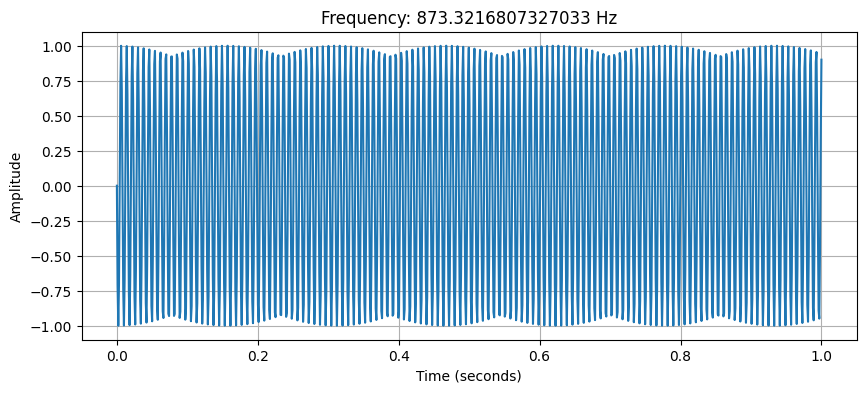

In [50]:
# Generate audio based on probability provided by the model

import soundfile as sf
import matplotlib.pyplot as plt

def play_tone(probability, duration=3.0, sample_rate=44100, volume=0.5):
    # Map probability to frequency range: 220 Hz to 880 Hz
    frequency = 880 - (probability * 660)  # Higher probability, lower frequency

    # Generate time array
    t = np.linspace(0, duration, int(sample_rate * duration), False)

    # Generate audio wave
    wave = np.sin(frequency * t * 2 * np.pi)

    # Ensure that highest value is in 16-bit range
    audio = wave * (32767 * volume)
    audio = audio.astype(np.int16)

    # Write audio to WAV file
    sf.write('/content/drive/MyDrive/KneeMRI/KneeTesting/probability_frequency_mapping_audio.wav', audio, sample_rate)

    # Constants
    time = np.linspace(0, 1, 1000)  # Time vector for 1 second

    # Sine wave calculation
    sine_wave = np.sin(2 * np.pi * frequency * time)

    # Plotting the sine wave
    plt.figure(figsize=(10, 4))
    plt.plot(time, sine_wave)
    plt.title(f"Frequency: {frequency} Hz")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Play a tone for the average of the model prediction values.
play_tone(average_probability)


Another Audio Example - Polyphonic Probability Mapping

In [58]:
import numpy as np
import soundfile as sf

def generate_polyphonic_tone(probability, duration=3.0, sample_rate=44100, volume=0.5):
    # Define frequency ranges for different probability segments
    frequencies = [220, 330, 440, 550, 660]  # Five different tones
    segments = [0.2, 0.4, 0.6, 0.8, 1.0]     # Corresponding probability thresholds

    # Generate time array
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    wave = np.zeros_like(t)

    # Generate waves for each segment
    for i, freq in enumerate(frequencies):
        segment_wave = np.sin(freq * t * 2 * np.pi)

        # Calculate volume for each segment based on proximity to the segment's probability range
        segment_volume = max(0, 1 - abs(probability - segments[i])*5)  # Scale and invert distance
        wave += segment_wave * segment_volume

    # Normalize and convert to 16-bit
    wave = (wave / len(frequencies)) * (32767 * volume)
    wave = wave.astype(np.int16)

    # Save audio
    sf.write('/content/drive/MyDrive/KneeMRI/KneeTesting/polyphonic_tone.wav', wave, sample_rate)

    print("Polyphonic tone generation completed.")

# Example usage
generate_polyphonic_tone(average_probability)


Another Audio Example - Stereo Panning Probability Mapping

In [78]:
import numpy as np
import soundfile as sf

def stereo_panning(probability, frequency=440, duration=3.0, sample_rate=44100):
    # Time array
    t = np.linspace(0, duration, int(sample_rate * duration), False)

    # Generate mono tone
    tone = np.sin(frequency * t * 2 * np.pi)

    # Stereo panning: calculate left and right volumes
    left_volume = 1.0 - probability
    right_volume = probability

    # Create stereo wave by duplicating the tone and applying the volumes
    stereo_wave = np.zeros((len(tone), 2))  # Two columns for two channels
    stereo_wave[:, 0] = tone * left_volume  # Left channel
    stereo_wave[:, 1] = tone * right_volume  # Right channel

    # Normalize to prevent clipping and convert to 16-bit
    max_val = np.max(np.abs(stereo_wave))
    if max_val > 0:
        stereo_wave = stereo_wave / max_val * 0.8  # Reduce a bit to avoid any clipping
    stereo_wave = (stereo_wave * 32767).astype(np.int16)

    # Save to a file
    sf.write('/content/drive/MyDrive/KneeMRI/KneeTesting/stereo_panning.wav', stereo_wave, sample_rate)

    print("Stereo panning probability mapping completed.")

# Example usage
stereo_panning(average_probability)


Stereo panning probability mapping completed.


Another Audio Example - Time Variation Probability Mapping

In [ ]:
import numpy as np
import soundfile as sf

def time_variation_tones(probabilities, frequency=440, tone_duration=0.5, max_gap=1.0, sample_rate=44100):
    # List to accumulate the audio samples
    audio = []

    # Generate each tone and its following gap
    for probability in probabilities:
        # Generate tone
        t = np.linspace(0, tone_duration, int(sample_rate * tone_duration), False)
        tone = np.sin(frequency * t * 2 * np.pi)

        # Normalize tone volume
        tone = (tone * 0.8 * 32767).astype(np.int16)
        audio.extend(tone)

        # Calculate gap duration based on probability (inverse relation)
        gap_duration = max_gap * (1 - probability)  # Higher probability, shorter gap
        gap = np.zeros(int(sample_rate * gap_duration)).astype(np.int16)
        audio.extend(gap)

    # Convert list to numpy array
    audio = np.array(audio)

    # Save to a file
    sf.write('/content/drive/MyDrive/KneeMRI/KneeTesting/time_variation_tones.wav', audio, sample_rate)

    print("Time variation probability mapping completed.")

# Example usage
time_variation_tones(probabilities)
